In [11]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nikhilroxtomar/brain-tumor-segmentation")

print("Path to dataset files:", path)

Mounting files to /kaggle/input/brain-tumor-segmentation...
Path to dataset files: /kaggle/input/brain-tumor-segmentation


**Import Module******

In [13]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers,models,Input
from tensorflow.keras.layers import Conv2D,MaxPooling2D,UpSampling2D,concatenate,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [14]:
np.random.seed(42)

**Preprocessing Steps**

In [17]:
def load_data(image_dir,mask_dir,img_size=(256,256)):
    images=[]
    masks=[]
    for img_name in os.listdir(image_dir):
        img_path=os.path.join(image_dir,img_name)
        mask_path=os.path.join(mask_dir,img_name)

        img=cv2.imread(img_path,cv2.IMREAD_COLOR)
        img=cv2.resize(img,img_size)/255.0
        mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
        mask=cv2.resize(mask,img_size)/255.0

        images.append(img)
        masks.append(mask[...,np.newaxis])

    return np.array(images),np.array(masks)

In [19]:
images,masks=load_data("/kaggle/input/brain-tumor-segmentation/images", "/kaggle/input/brain-tumor-segmentation/masks")

In [22]:
def build_hybrid_unet(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(input_shape)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    # Bottleneck
    b1 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    
    # Decoder
    u3 = UpSampling2D((2, 2))(b1)
    u3 = concatenate([u3, c3])
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    
    u2 = UpSampling2D((2, 2))(c4)
    u2 = concatenate([u2, c2])
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
    
    u1 = UpSampling2D((2, 2))(c5)
    u1 = concatenate([u1, c1])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
    
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c6)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = build_hybrid_unet()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
checkpoint=ModelCheckpoint('/kaggle/working/hybrid_unet_best.keras',monitor='val_loss',save_best_only=True,mode='min')
early_stop=EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

history=model.fit(images,masks,validation_split=0.2,epochs=10,batch_size=8,callbacks=[checkpoint,early_stop])

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 260s 678ms/step - accuracy: 0.9638 - loss: 0.1774 - val_accuracy: 0.9824 - val_loss: 0.0809
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 153s 498ms/step - accuracy: 0.9824 - loss: 0.0646 - val_accuracy: 0.9824 - val_loss: 0.0536
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 152s 494ms/step - accuracy: 0.9835 - loss: 0.0515 - val_accuracy: 0.9843 - val_loss: 0.0515
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 151s 493ms/step - accuracy: 0.9854 - loss: 0.0459 - val_accuracy: 0.9862 - val_loss: 0.0430
Epoch 5/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 153s 499ms/step - accuracy: 0.9875 - loss: 0.0374 - val_accuracy: 0.9870 - val_loss: 0.0382
Epoch 6/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 152s 494ms/step - accuracy: 0.9883 - loss: 0.0326 - val_accuracy: 0.9887 - val_loss: 0.0319
Epoch 7/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 152s 496ms/step - accuracy: 0.9897 - loss: 0.0287 - val_accuracy: 0.9884 - val_loss: 0.0325
Epoch 8/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 152s 495ms/step - accuracy: 0.9909 -

In [26]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

#Load The trained model
model=load_model('/kaggle/working/hybrid_unet_best.keras')



In [37]:
#Preprocess the input
def preprocess_image(image_path,image_size=(256,256)):
    image=cv2.imread(image_path,cv2.IMREAD_COLOR)
    image=cv2.resize(image,image_size)
    image=image/255.0
    return np.expand_dims(image,axis=0)

In [38]:
#Predict on single input image
def predict_single_image(model,image_path):
    preprocessed_image=preprocess_image(image_path)
    prediction=model.predict(preprocessed_image)

    prediction=prediction[0,:,:,0]
    prediction=(prediction>0.5).astype(np.uint8)

    return prediction

In [39]:
image_path= '/kaggle/input/brain-tumor-segmentation/images/1003.png'
predicted_mask=predict_single_image(model,image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


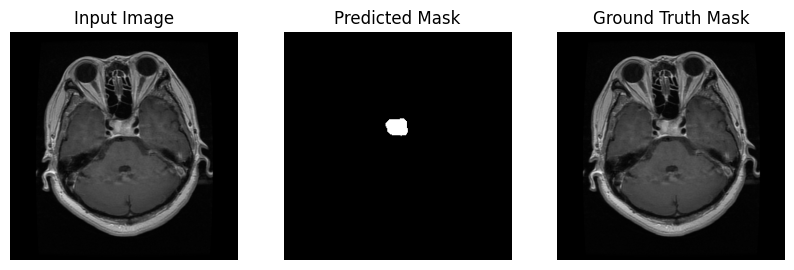

In [45]:
#Display the input image and predicted mask

input_image=cv2.imread(image_path,cv2.IMREAD_COLOR)
input_image=cv2.cvtColor(input_image,cv2.COLOR_BGR2RGB)

ground_truth=cv2.imread('/kaggle/input/brain-tumor-segmentation/images/1003.png')
ground_trouth=cv2.cvtColor(ground_truth,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(ground_truth, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.show()

In [47]:
model.save('my_trained_model.h5')